Instead of calculating these rates directly from the rows of the table, we compute it by imposing an **incremental update**. 

$$ R_*^t \leftarrow \eta_*R_*^{(t-1)} + (1 - \eta_*) I_{y_t = \hat{y}_t} $$

- Current rate $ R_*^t $ where $ * \in \{tnr, tpr, ppv, npv\}$
- Time decaying factor $\eta_*$
- Previous rate $ R_*^{(t-1)} $ where $ * \in \{tnr, tpr, ppv, npv\}$
- Indicator function checking if the actual label and the predicted label are equal.


<div class="alert alert-block alert-warning">
<b>What is the time-decaying factor $\eta_*$?</b> 

$ R_*^t $ will be updated using the above **incremental update** equation at time step $t$ provided we have true labels for all predictions, where $\eta_*$ is a time decay factor of range $(0 < \eta_* < 1)$ for emphasising the learner’s performance at the current moment. Notably, when $\{y_t = \hat{y}_t\}$ is true $I_{y_t = \hat{y}_t}$ is equal to 1 (i.e.  $I = 1$  if correct classification occurs and 0 otherwise).
    
We choose time decayed $ R_*^t $ here rather than the traditional prequential metrics $\{tnr, tpr, ppv, npv\}$ without applying the time decay factor, because the former has been shown to be able to better reflect the current performance of the online model in non-stationary environments without forgetting its past performance too much. It is expected to be more sensitive to concept drift, and thus could be a better indicator for concept drift detection. 
    
A value of $0.9$ is chosen for $\eta_*$ in our experiments to be in line with literature. The optimal selection of $\eta_*$ is however, domain dependent and can be pre-learned if necessary.
   
</div>

This time-decaying factor $\eta_*$ can be made adaptive through the below modifications: 

$$ 
\eta_* = \left\{
\begin{array}{ll}
      (\eta_*^{(t-1)} - 1)e^{-(R_*^{(t)} - R_*^{(t-1)})} + 1 & R_*^{(t)} \geq R_*^{(t-1)} \\
      (1 - \eta_*^{(t-1)})e^{(R_*^{(t)} - R_*^{(t-1)})} + (2\eta_*^{(t-1)} - 1) & R_*^{(t)} < R_*^{(t-1)} \\
\end{array} 
\right.
$$

The key idea is that once  $ R_*$ is increased, the system tends to perform better with recent data, which suggests the feasibility of a larger time decaying factor, and vice versa.

<!-- A change in any of these $ P_*^t $ where $ * \in \{tnr, tpr, ppv, npv\}$ indicates a change in the underlying mapping between the independent features and the target variable. More specifically at each time instant $t$, LFR conducts 4 independent tests with the following null and alternative hypothesis. 

$$ H_0 : \forall_*, P(\hat{P}_*^{(t-1)}) = P(\hat{P}_*^{(t)}) $$
$$ H_A : \exists_*, P(\hat{P}_*^{(t-1)}) \neq P(\hat{P}_*^{(t)}) $$

If the null hypothesis $H_0$ holds true that the concept is considered to be stable, however, if $H_0$ is rejected then there is a potential drift. 
 -->
### Benefits 
Since we are monitoring 4 different types of errors/rates seperately LFR is senstive and typically better than (E)DDM for 
- class imbalance.
- shorter detection delay 
- higher detection precision


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T = 10000
changepoint = 5000

In [3]:
# np.random.seed(1234)
np.random.seed(1998)

# Generate sme synthetic data
possibilities = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
cp1 = [0.4, 0.1, 0.1, 0.4]
cp2 = [0.3, 0.1, 0.2, 0.4]
first_sample_idx = np.random.choice(len(possibilities), changepoint, replace=True, p=cp1)
second_sample_idx = np.random.choice(len(possibilities), changepoint, replace=True, p=cp2)

In [4]:
sampled_data = np.vstack((possibilities[first_sample_idx], possibilities[second_sample_idx]))
y_true = sampled_data[:, 0]
y_pred = sampled_data[:, 1]

In [5]:
y_true

array([1, 1, 0, ..., 0, 1, 1])

In [6]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

### The Four Rates

In [7]:
def compute_tpr(confusion_matrix):
    return confusion_matrix.tp / (confusion_matrix.tp + confusion_matrix.fn)


def compute_tnr(confusion_matrix):
    return confusion_matrix.tn / (confusion_matrix.tn + confusion_matrix.fp)


def compute_ppv(confusion_matrix):
    return confusion_matrix.tp / (confusion_matrix.tp + confusion_matrix.fp)


def compute_npv(confusion_matrix):
    return confusion_matrix.tn / (confusion_matrix.tn + confusion_matrix.fn)


METRICS_FUNCTION_MAPPING = {
    'tpr': compute_tpr,
    'tnr': compute_tnr,
    'ppv': compute_ppv,
    'npv': compute_npv
}

In [8]:
MM = np.ones((2, 2))
MM

array([[1., 1.],
       [1., 1.]])

In [9]:
MM[0, 1] += 1
MM

array([[1., 2.],
       [1., 1.]])

### Streaming Confusion Matrix

In [10]:
class StreamingConfusionMatrix(object):
    def __init__(self):
        self.confusion_matrix = np.ones((2, 2))
        self.tp = 1
        self.fp = 1
        self.tn = 1
        self.fn = 1

    def update_confusion_matrix(self, y_true, y_pred):
        self.confusion_matrix[y_pred, y_true] += 1
        self.update_statistics()
        
        return self.confusion_matrix

    def update_statistics(self):
        self.tp = self.confusion_matrix[1, 1]
        self.fp = self.confusion_matrix[1, 0]
        self.tn = self.confusion_matrix[0, 0]
        self.fn = self.confusion_matrix[0, 1]
        

### Performance Metric

In [11]:
class PerformanceMetric(object):
    def __init__(self, metric_name, decay):
        
        self.metric_name = metric_name
        self.decay = decay #[0.7]
        self.metric_value = [0.5]
        self.R = [0.5]
    
    def reset_internals(self):
        self.decay = decay #[0.7]
        self._R[-1] = 0.5
        self._P[-1] = 0.5

    def update_metric(self, confusion_matrix, y_actual, y_pred):

        self.metric_value.append(METRICS_FUNCTION_MAPPING[self.metric_name](confusion_matrix))
        r_hat, decay_t = self.update_decay(y_actual, y_pred)

        return r_hat, decay_t

    def update_decay(self, y_actual, y_pred):
        if (abs(self.metric_value[-1] - self.metric_value[-2]) > 0):
            self.R.append(self.decay[-1] * self.R[-1] + (1 - self.decay[-1]) * int(y_actual == y_pred))
        else:
            self.R.append(self.R[-1])
            
        if (self.R[-1] < self.R[-2]):
            self.decay.append((1 - self.decay[-1])*np.exp(self.R[-1] - self.R[-2]) + (2*self.decay[-1] - 1))
        else:
            self.decay.append((self.decay[-1] - 1)*np.exp(-(self.R[-1] - self.R[-2])) + 1)
            
        return self.R, self.decay

In [12]:
metric_choice = 'tpr'
decay = [0.9]
metrics = {metric_choice: PerformanceMetric(metric_choice, decay)}
confusion_matrix = StreamingConfusionMatrix()

In [13]:
import pandas as pd

b=[]
data = pd.DataFrame([])
#decay_t = [0.9]

for t, (y, y_hat) in enumerate(zip(y_true[:30], y_pred[:30])):
    
    #print("for:", t, confusion_matrix.confusion_matrix.ravel(), ' <-- ', y, y_hat, '-->', 
    #      round(r_hat[t],4), "?", (metric.metric_value[-1]==metric.metric_value[-2]), (y==y_hat))
    
   
    
    
    
    confusion_matrix.update_confusion_matrix(y, y_hat)
   

    for metric in metrics.values():
        r_hat, decay_t = metric.update_metric(confusion_matrix, y, y_hat)
    
    aa,ab,ac,ad = confusion_matrix.confusion_matrix.ravel()  
    a = (t, aa,ab,ac,ad, y, y_hat, round(r_hat[t],4), round(decay_t[t],4),
                    (metric.metric_value[-1]==metric.metric_value[-2]), 
                    (y==y_hat))
    b.append(a)
    
f = pd.DataFrame(b)
f.columns = ['t', "TN", 'FP', 'FN', 'TP','Y', 'Yhat', 'Rhat', 'Decay n', 'metricvalue_1_2', 'Y_Yhat']


In [15]:
f.tail()

,t,TN,FP,FN,TP,Y,Yhat,Rhat,Decay n,metricvalue_1_2,Y_Yhat
25,25,9.0,5.0,4.0,12.0,1,1,0.6756,0.9170,False,True
26,26,9.0,5.0,4.0,13.0,1,1,0.7025,0.9192,False,True
27,27,9.0,6.0,4.0,13.0,1,0,0.7266,0.9212,False,False
28,28,10.0,6.0,4.0,13.0,0,0,0.6693,0.9168,True,True
29,29,11.0,6.0,4.0,13.0,0,0,0.6693,0.9168,True,True


In [408]:
0.9010 * 0.5077 + (1 - 0.9010) * 1 #4th element

#decay * previous R + (1-decay) * 1 if last Y = yhat

0.5564377

In [409]:
0.9212 * 0.7266 + (1 - 0.9212) * 0 #28th element
#decay * previous R + (1-decay) * 1 if last Y <> yhat

0.66934392

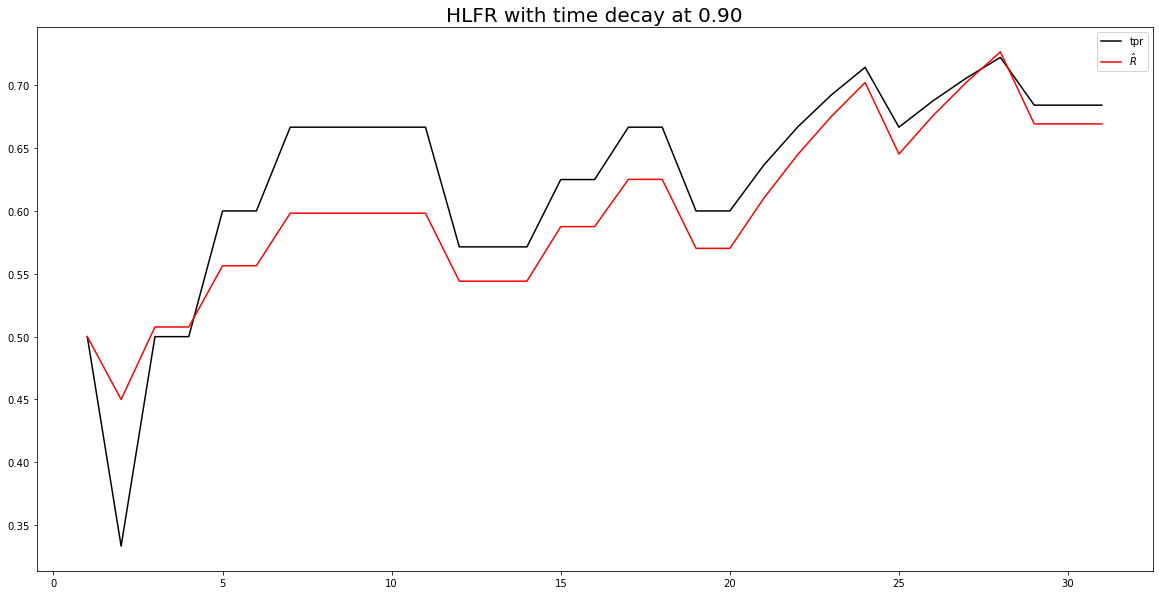

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
time = np.arange(1, 32)
ax.plot(time, metrics[metric_choice].metric_value, 'black',label=metric_choice)
ax.plot(time, r_hat, 'r-',label=r'$\hat{R}$')
plt.title('HLFR with time decay at 0.90', fontsize=20)
ax.legend()
plt.show()

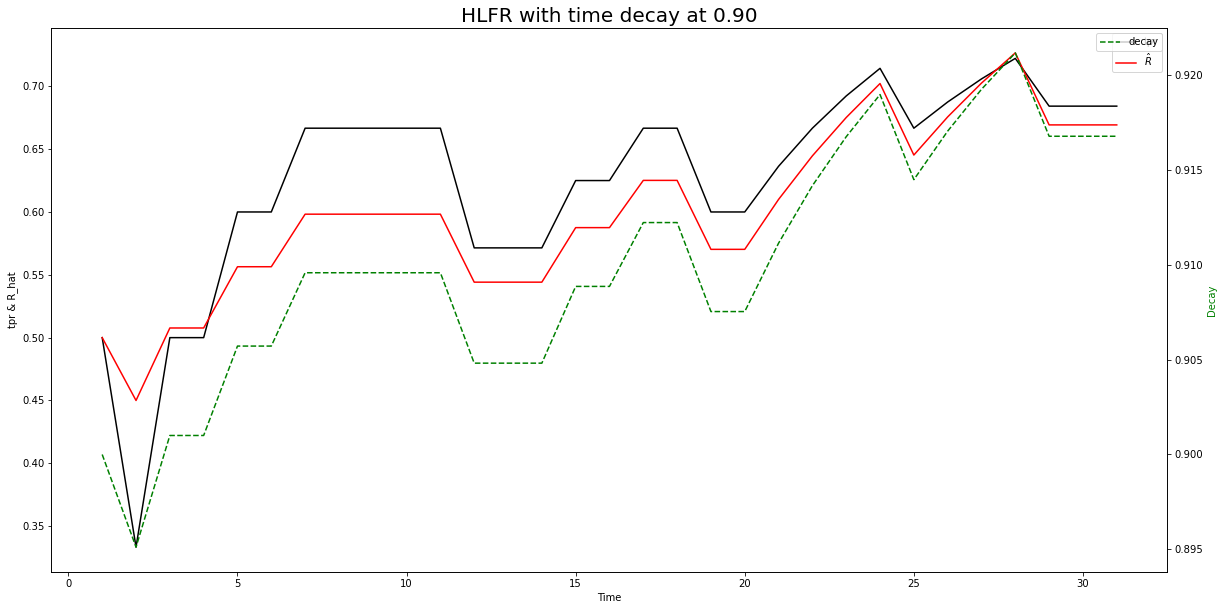

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10))
ax2 = ax1.twinx()

time = np.arange(1, 32)


ax1.plot(time, metrics[metric_choice].metric_value, 'black',label=metric_choice)
ax1.plot(time, r_hat, 'r-',label=r'$\hat{R}$')
ax2.plot(time, decay_t, 'g--', label='decay')

ax1.set_xlabel('Time')
ax1.set_ylabel(metric_choice+' & R_hat')
ax2.set_ylabel('Decay', color='g')

ax1.legend()
ax2.legend()

plt.title('HLFR with time decay at 0.90', fontsize=20)
plt.show()

## All four rates: tpr, tnr, ppv, npv 
### Decay = 0.9

In [13]:
days = 30
decay = 0.9
monitor_metrics = ['tpr', 'tnr', 'ppv', 'npv']

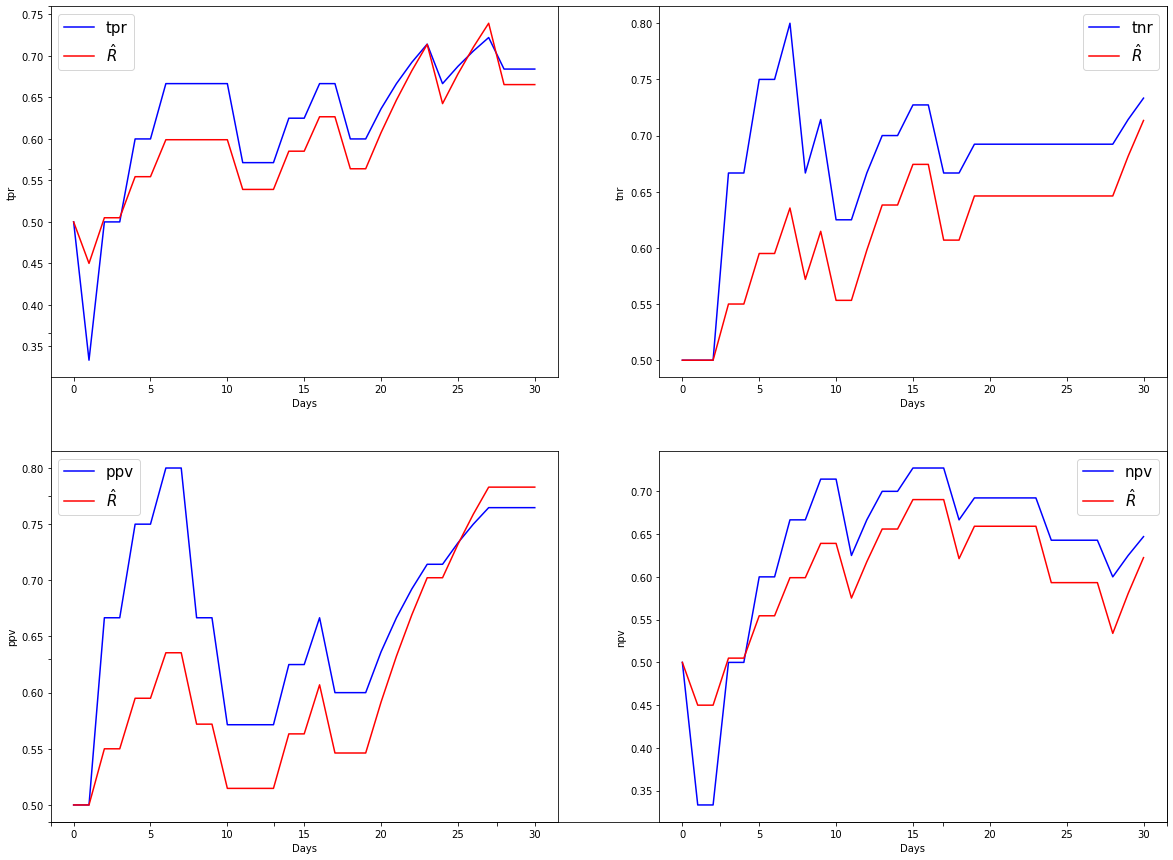

In [14]:
fig, ax = plt.subplots(figsize=(20,15))
ax.tick_params(labelbottom=False, labelleft=False) 

for met in range(0, len(monitor_metrics)):
    metric_choice = monitor_metrics[met]
    metrics = {metric_choice: PerformanceMetric(metric_choice, decay)}
    confusion_matrix = StreamingConfusionMatrix()
    
    for t, (y, y_hat) in enumerate(zip(y_true[:days], y_pred[:days])):
        confusion_matrix.update_confusion_matrix(y, y_hat)

        for metric in metrics.values():
            r_hat = metric.update_metric(confusion_matrix, y, y_hat)

    ax = fig.add_subplot(2,2,met+1)
    time = np.arange(0, days+1)
    plt.plot(time, metrics[metric_choice].metric_value, 'b-',label=metric_choice)
    plt.plot(time, r_hat, 'r-',label=r'$\hat{R}$')
    plt.legend(fontsize=15)
    plt.xlabel('Days')
    plt.ylabel(metric_choice)

### Decay = 0.7

In [15]:
decay = 0.7

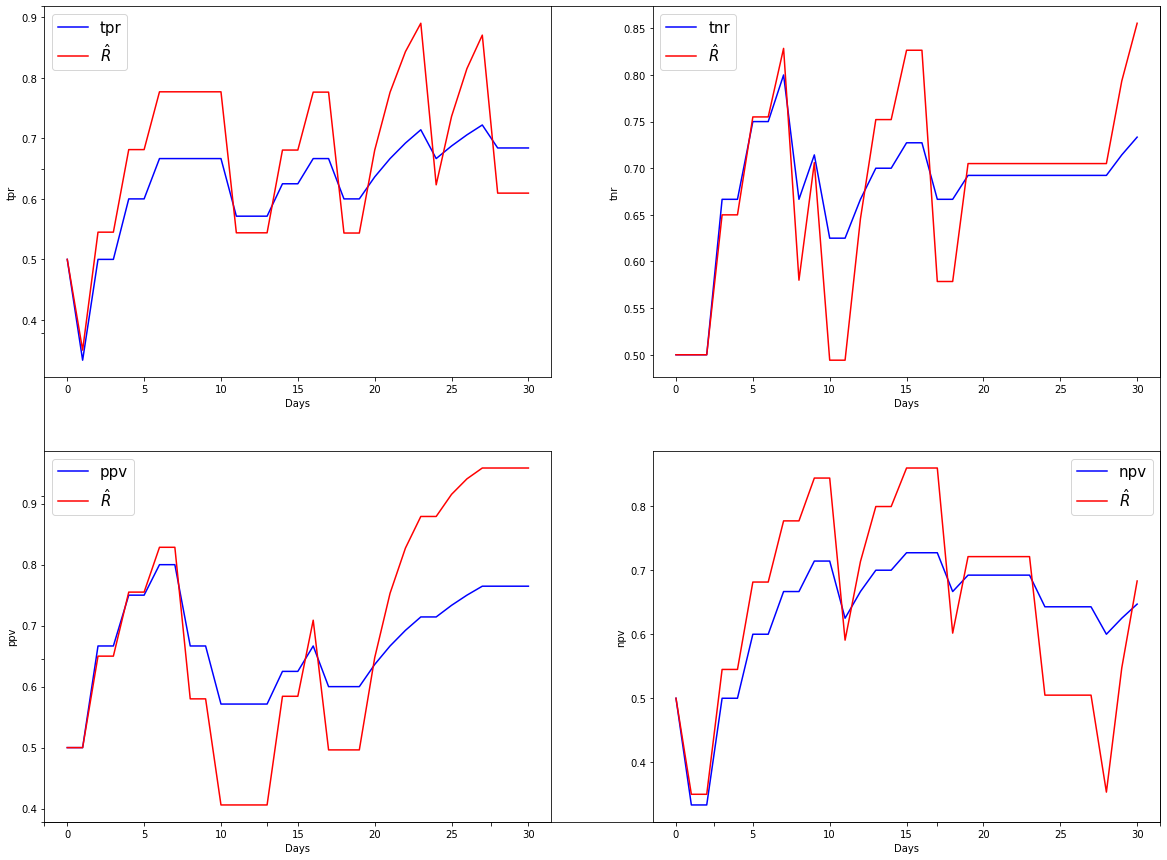

In [16]:
fig, ax = plt.subplots(figsize=(20,15))
ax.tick_params(labelbottom=False, labelleft=False) 

for met in range(0, len(monitor_metrics)):
    metric_choice = monitor_metrics[met]
    metrics = {metric_choice: PerformanceMetric(metric_choice, decay)}
    confusion_matrix = StreamingConfusionMatrix()
    
    for t, (y, y_hat) in enumerate(zip(y_true[:days], y_pred[:days])):
        confusion_matrix.update_confusion_matrix(y, y_hat)

        for metric in metrics.values():
            r_hat = metric.update_metric(confusion_matrix, y, y_hat)

    ax = fig.add_subplot(2,2,met+1)
    time = np.arange(0, days+1)
    plt.plot(time, metrics[metric_choice].metric_value, 'b-',label=metric_choice)
    plt.plot(time, r_hat, 'r-',label=r'$\hat{R}$')
    plt.legend(fontsize=15)
    plt.xlabel('Days')
    plt.ylabel(metric_choice)

In [278]:
alpha = 2
q=[alpha * 100, (1 - alpha) * 100]
q

[200, -100]

In [282]:
import numpy as np
import numpy as np
import itertools
import math

from scipy.stats import bernoulli


In [289]:
p_hat = y_pred[:30]
n_sim=1000
n=9
p_hat=True
bernoulli_samples = bernoulli.rvs(p_hat, size=n * n_sim).reshape(n_sim, n)
bernoulli_samples

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])